In [2]:
###### load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

# import paired ttest
from scipy.stats import ttest_rel
from scipy.stats import wilcoxon

# needed for editable text in svg format
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['text.usetex'] = False
plt.rcParams['svg.fonttype'] = 'none'

# import homemade functions:
from MAPseq_processing import *
from MAPseq_plotting import *

# import metadata
from M194_M220_metadata import *

# import colormaps
from colormaps import blue_cmp, orange_cmp

%matplotlib inline

# auto refreshes imported functions if source code changes:
%load_ext autoreload
%autoreload 2


In [8]:
# set-up variables
in_path = '/Volumes/Data/Emily/MAPseq/combined_analysis_M194_M220/processed_data/'
# out_path = '/Volumes/Data/Emily/figures/fig_3_sc/python_out/'
# out_path = '/Volumes/Data/Emily/figures/fig_2_mapseq/figure_pics/'
out_path = "/Users/eisko/Documents/CSHL/mapseq_paper/svg_images/"

#### load data - OMC
omc_bin = pd.read_pickle(in_path+"M194_M220_OMC_bin4.pkl")
# omc_countN = pd.read_pickle(in_path+"M194_M220_OMC_countN4.pkl")

# Preprocessing/sorting
## initial processing - OMC


# bin processing
omc_clean = [clean_up_data(df) for df in omc_bin]
omc_type = [sort_by_celltype(df) for df in omc_clean]

# seperate it cells
omc_it = [df[df['type']=="IT"] for df in omc_type]

# seperate pt cells
omc_pt = [df[df['type']=="PT"] for df in omc_type]

# seperate then concatenate by species
mm_it = [omc_it[i] for i in range(len(omc_it)) if metadata.loc[i,"species"]=="MMus"]
st_it = [omc_it[i] for i in range(len(omc_it)) if metadata.loc[i,"species"]=="STeg"]
mm_it_all = pd.concat(mm_it)
st_it_all = pd.concat(st_it)

mm_pt = [omc_pt[i] for i in range(len(omc_pt)) if metadata.loc[i,"species"]=="MMus"]
st_pt = [omc_pt[i] for i in range(len(omc_pt)) if metadata.loc[i,"species"]=="STeg"]
mm_pt_all = pd.concat(mm_pt)
st_pt_all = pd.concat(st_pt)


# IT Cells

In [43]:
plot_areas = ["OMCc", "AUD", "STR"]

# Estimate n-totals
n_totals = [estimate_n_total(omc_it[i], plot_areas) for i in range(len(omc_it))]

# Count obs motifs
n_obs_motifs = [df_to_motif_proportion(df, areas=plot_areas, proportion=False) for df in omc_it]
motifs = n_obs_motifs[0].index

# convert to proportions using adjusted n_totals
p_obs_motifs = [n_obs_motifs[i]/n_totals[i] for i in range(len(n_totals))]

# calculate proportions based on independent bulk probabilities adjusted for n_total
p_calc_motifs = [df_to_calc_pab_proportions(df, motifs, adjust_total=True) for df in omc_it]

motif_strings = TF_to_motifs(motifs)

# put into dataframe - note p_obs is adjusted for n_total
it_motifs_df = []
for i in range(len(n_totals)):
    df = pd.DataFrame({"motifs":motif_strings, "n_shape":omc_it[i].shape[0], "n_total":n_totals[i],
                  "n_obs":n_obs_motifs[i], "p_obs":p_obs_motifs[i], "p_calc":p_calc_motifs[i],
                  "mice":metadata.loc[i,"mice"], "species":metadata.loc[i,"species"]})
    it_motifs_df.append(df)
it_motifs_df = pd.concat(it_motifs_df).reset_index(drop=True)

it_motifs_df

,motifs,n_shape,n_total,n_obs,p_obs,p_calc,mice,species
0,OMCc_,8287,8949,1123,0.125489,0.124100,MMM1,MMus
1,AUD_,8287,8949,3,0.000335,0.000980,MMM1,MMus
2,STR_,8287,8949,2668,0.298134,0.294598,MMM1,MMus
3,AUD_OMCc_,8287,8949,8,0.000894,0.001644,MMM1,MMus
4,OMCc_STR_,8287,8949,4379,0.489328,0.494259,MMM1,MMus
...,...,...,...,...,...,...,...,...
79,STR_,527,530,29,0.054717,0.053811,STM7,STeg
80,AUD_OMCc_,527,530,9,0.016981,0.018997,STM7,STeg
81,OMCc_STR_,527,530,351,0.662264,0.659190,STM7,STeg
82,AUD_STR_,527,530,4,0.007547,0.014256,STM7,STeg


In [44]:
# plot paired dot plot

# isolate to singing mice
steg = it_motifs_df[it_motifs_df["species"]=="STeg"].reset_index(drop=True)

# calculate fold change (p_obs/p_calc)

# reform so that can use seaborn to plot
exp_steg_plot = steg.copy()
obs_steg_plot = steg.copy()
exp_steg_plot["proportion"] = steg["p_calc"]
obs_steg_plot["proportion"] = steg["p_obs"]
exp_steg_plot["compare"] = "expected"
obs_steg_plot["compare"] = "obeserved"

steg_plot = pd.concat([exp_steg_plot, obs_steg_plot]).drop(columns=["p_obs", "p_calc"]).reset_index(drop=True)

steg_plot



,motifs,n_shape,n_total,n_obs,mice,species,proportion,compare
0,OMCc_,535,555,64,STM1,STeg,0.110635,expected
1,AUD_,535,555,4,STM1,STeg,0.004604,expected
2,STR_,535,555,99,STM1,STeg,0.184259,expected
3,AUD_OMCc_,535,555,4,STM1,STeg,0.013914,expected
4,OMCc_STR_,535,555,310,STM1,STeg,0.556782,expected
...,...,...,...,...,...,...,...,...
93,STR_,527,530,29,STM7,STeg,0.054717,obeserved
94,AUD_OMCc_,527,530,9,STM7,STeg,0.016981,obeserved
95,OMCc_STR_,527,530,351,STM7,STeg,0.662264,obeserved
96,AUD_STR_,527,530,4,STM7,STeg,0.007547,obeserved


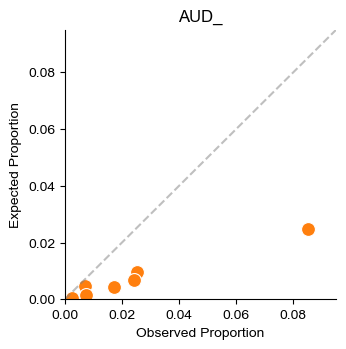

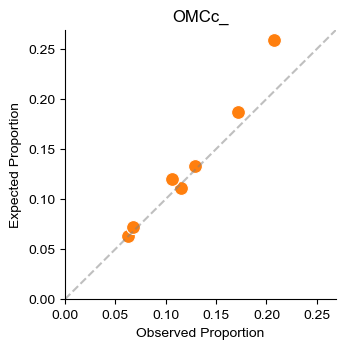

In [45]:
# single motif x/y plot

plot_motifs = ["AUD_", "OMCc_"]


for m in plot_motifs:
    fig, axs = plt.subplots(1,1, figsize=(3.5,3.5))

    plot_df = steg[steg["motifs"]==m]


    sns.scatterplot(plot_df, x="p_obs", y="p_calc", color="tab:orange", s=100)
    plt.title(m)

    plt.xlabel("Observed Proportion")
    plt.ylabel("Expected Proportion")

    # draw x=y line
    plt.axline((0,0), (0.02, 0.02), color="gray", linestyle="--", alpha=0.5)

    # get max to get bounds to plot
    max = pd.concat([plot_df["p_calc"], plot_df["p_obs"]]).max()
    plt.xlim(0,max+0.01)
    plt.ylim(0,max+0.01)

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # plt.savefig(out_path+m+"_steg_obs_exp_scatter.svg", dpi=300, bbox_inches="tight")

    plt.show()

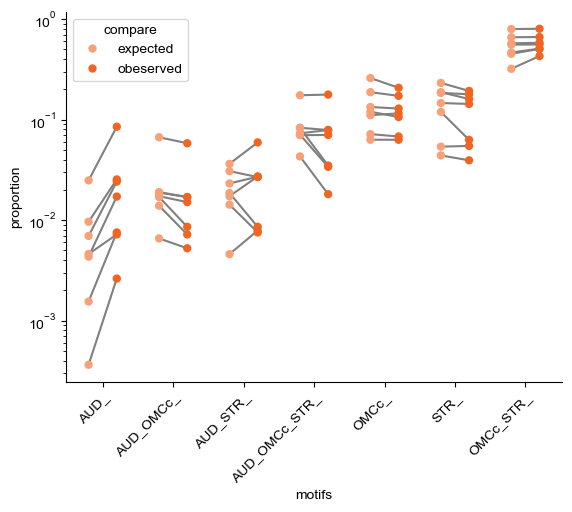

In [46]:
# plot

# set colors for plot
colors = [orange_cmp.colors[-100], orange_cmp.colors[-1]]
# set order of xaxis
order = ["AUD_", "AUD_OMCc_", "AUD_STR_", "AUD_OMCc_STR_", "OMCc_", "STR_", "OMCc_STR_"]

ax = sns.stripplot(x='motifs', y='proportion', hue='compare', palette=[colors[0], colors[1]],
                   dodge=.3, data=steg_plot, jitter=0, size=6, order=order)

for i in range(len(steg["motifs"].unique())):
    for (x0, y0), (x1, y1) in zip(ax.collections[2*i].get_offsets(), ax.collections[2*i+1].get_offsets()):
        ax.plot([x0, x1], [y0, y1], color='grey', zorder=0)
# rotate xaxis labels
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

# set yaxis on log
plt.yscale("log")

# get rid of top/side axis
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.savefig(out_path+"_steg_individ_paired.svg", dpi=300, bbox_inches="tight")

plt.show()


In [47]:
# # set colors for plot
# colors = [orange_cmp.colors[-100], orange_cmp.colors[-1]]
# # set order of xaxis
# order = ["AUD_", "AUD_OMCc_", "AUD_STR_", "AUD_OMCc_STR_", "OMCc_", "STR_", "OMCc_STR_"]

# ax = sns.pointplot(x='motifs', y='proportion', hue='compare', palette=[colors[0], colors[1]],
#                    dodge=.3, data=steg_plot, order=order, ls="")

# # for i in range(len(motifs)):
# #     for (x0, y0), (x1, y1) in zip(ax.collections[2*i].get_offsets(), ax.collections[2*i+1].get_offsets()):
# #         ax.plot([x0, x1], [y0, y1], color='grey', zorder=0)

# # set yaxis on log
# plt.yscale("log")
# # rotate xaxis labels
# plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
# # get rid of top/side axis
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

# plt.savefig(out_path+"_steg_avg_se.svg", dpi=300, bbox_inches="tight")

# plt.show()

In [48]:
# sns.scatterplot(steg, x="p_obs", y="p_calc", hue="motifs", style="mice")
# # plot on log scale
# plt.title("IT - Log scale")
# plt.xscale("log")
# plt.yscale("log")
# plt.axline((0,0), (0.6,0.6), color="red", linestyle="--", alpha=0.5)
# plt.legend(bbox_to_anchor=(1, 1))
# plt.xlabel("Observed proportion")
# plt.ylabel("Expected proportion")
# plt.savefig(out_path+"steg_motif_all_scatter.svg", dpi=300, bbox_inches="tight")
# plt.show()

<>:26: SyntaxWarning: invalid escape sequence '\d'
<>:26: SyntaxWarning: invalid escape sequence '\d'
/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_17484/3486898282.py:26: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel('$log_{2}$($\dfrac{Observed}{Expected}$)')


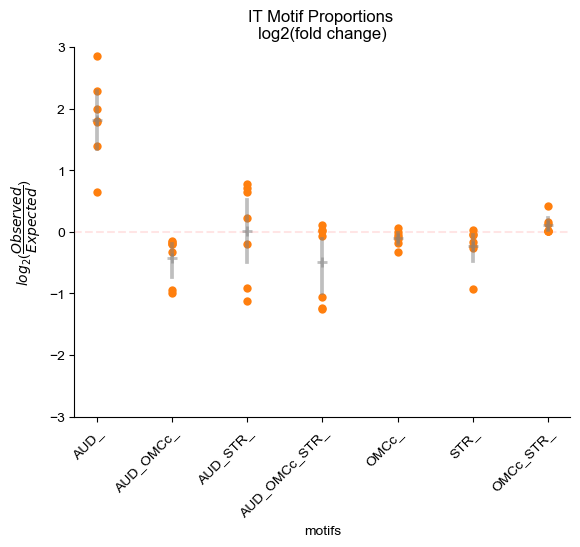

In [49]:
# match to steg expected (p_calc) mean?

# calculate fold change
# Calculate foldchange:
steg["fc"] = steg["p_obs"]/steg["p_calc"]
steg["log2fc"] = np.log2(steg["fc"])


sns.stripplot(x='motifs', y='log2fc', color="tab:orange",
                data=steg, jitter=0, size=6, order=order)
sns.pointplot(steg, x="motifs", y="log2fc", order=order, color="gray",
              alpha=0.5, ls="", zorder=10, marker="+")
plt.axline((0,0), (1,0), color="red", ls="--", alpha=0.1)

# rotate xaxis labels
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

# set limits to equal
plt.ylim(-3,3)

# get rid of top/side axis
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.ylabel('$log_{2}$($\dfrac{Observed}{Expected}$)')

plt.title("IT Motif Proportions \nlog2(fold change)")

# plt.savefig(out_path+"steg_log2fc_motifs.svg", dpi=300, bbox_inches="tight")

plt.show()

In [58]:
steg[0:10]

,motifs,n_shape,n_total,n_obs,p_obs,p_calc,mice,species,fc,log2fc
0,OMCc_,535,555,64,0.115315,0.110635,STM1,STeg,1.042306,0.059779
1,AUD_,535,555,4,0.007207,0.004604,STM1,STeg,1.565263,0.646405
2,STR_,535,555,99,0.178378,0.184259,STM1,STeg,0.968087,-0.046792
3,AUD_OMCc_,535,555,4,0.007207,0.013914,STM1,STeg,0.518001,-0.948974
4,OMCc_STR_,535,555,310,0.558559,0.556782,STM1,STeg,1.003191,0.004597
5,AUD_STR_,535,555,15,0.027027,0.023172,STM1,STeg,1.166341,0.221989
6,AUD_OMCc_STR_,535,555,39,0.070270,0.070021,STM1,STeg,1.003557,0.005122
7,OMCc_,443,472,50,0.105932,0.119846,STM2,STeg,0.883902,-0.178042
8,AUD_,443,472,12,0.025424,0.009641,STM2,STeg,2.637121,1.398964
9,STR_,443,472,91,0.192797,0.231560,STM2,STeg,0.832600,-0.264305


In [60]:
# try out the wilcoxon signed rank test, non-normal equivalent of the paired ttest

wilcox_test = {}
for m in steg["motifs"].unique():
    df_m = steg[steg["motifs"]==m]
    wilcox_test[m] = wilcoxon(df_m["p_calc"], df_m["p_obs"])
wilcox_test


{'OMCc_': WilcoxonResult(statistic=3.0, pvalue=0.078125),
 'AUD_': WilcoxonResult(statistic=0.0, pvalue=0.015625),
 'STR_': WilcoxonResult(statistic=1.0, pvalue=0.03125),
 'AUD_OMCc_': WilcoxonResult(statistic=0.0, pvalue=0.015625),
 'OMCc_STR_': WilcoxonResult(statistic=0.0, pvalue=0.015625),
 'AUD_STR_': WilcoxonResult(statistic=13.0, pvalue=0.9375),
 'AUD_OMCc_STR_': WilcoxonResult(statistic=7.0, pvalue=0.296875)}

In [53]:
# # calcualte estimation confidence interval

# # create df to save combinations
# motif_strings = steg["motifs"].unique()
# st_est_log2fc = pd.DataFrame(columns=motif_strings)

# # cycle through all motifs
# for m in motif_strings:
#     st_m = steg[steg['motifs']== m]
#     p_calc = st_m["p_calc"].reset_index(drop=True)
#     st_m_est = pd.DataFrame(p_calc).rename(columns={"p_calc":"exp0"})
#     for i in range(p_calc.shape[0]):
#         shifted = p_calc.reindex(index=np.roll(p_calc.index, -i+1))
#         st_m_est["exp"+str(i)] = shifted.values

#     combos = pd.DataFrame(np.triu(st_m_est))
#     combos.replace(0, np.nan, inplace=True)
#     pairs = []
#     for i in range(combos.shape[0]-1):
#         pairs.append(combos.iloc[:,i]/combos.iloc[:,combos.shape[0]-1])
#     fc = np.array(pairs).flatten()
#     fc = fc[~np.isnan(fc)]
#     log2fc = np.log2(fc)

#     st_est_log2fc[m] = log2fc
# st_est_log2fc


In [52]:
# fig, axs = plt.subplots(3,3, figsize=(15,15))

# i=0
# for ax in axs.flat:
#     if i >= len(motif_strings):
#         ax.axis("off")
#     else:
            
#         motif = motif_strings[i]
#         data = st_est_log2fc[motif]
#         # plot histogram
#         ax.hist(data, color="tab:orange")
#         # add mu/sigma
#         mu = data.mean()
#         median = np.median(data)
#         sigma = data.std()
#         textstr = '\n'.join((
#             r'$\mu=%.2f$' % (mu, ),
#             r'$\mathrm{median}=%.2f$' % (median, ),
#             r'$\sigma=%.2f$' % (sigma, )))

#         # place a text box in upper left in axes coords
#         ax.text(0.01, 0.95, textstr, transform = ax.transAxes,
#                 verticalalignment='top')
#         ax.set_title(motif)
#         ax.spines['right'].set_visible(False)
#         ax.spines['top'].set_visible(False)

#         ax.set_xlim(-6,6)

#         # plot p_obs values for each motif
#         st_m = steg[steg["motifs"]==motif]
#         ax.vlines(st_m["log2fc"], ymin=0, ymax=6)
#     i+=1

# plt.show()

## mmus

In [61]:
# plot paired dot plot
plot_areas = ["OMCc", "AUD", "STR"]


# isolate to singing mice
mmus = it_motifs_df[it_motifs_df["species"]=="MMus"].reset_index(drop=True)

# reform so that can use seaborn to plot
exp_mmus_plot = mmus.copy()
obs_mmus_plot = mmus.copy()
exp_mmus_plot["proportion"] = mmus["p_calc"]
obs_mmus_plot["proportion"] = mmus["p_obs"]
exp_mmus_plot["compare"] = "expected"
obs_mmus_plot["compare"] = "obeserved"

mmus_plot = pd.concat([exp_mmus_plot, obs_mmus_plot]).drop(columns=["p_obs", "p_calc"]).reset_index(drop=True)



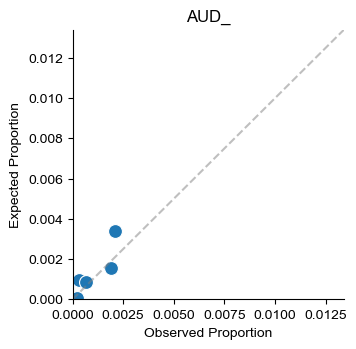

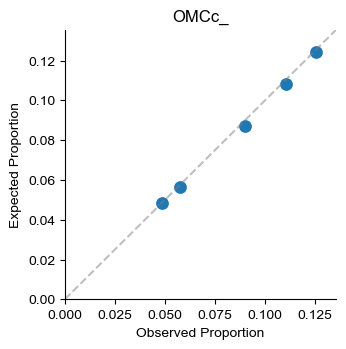

In [62]:
# single morif x/y plot

plot_motifs = ["AUD_", "OMCc_"]


for m in plot_motifs:
    fig, axs = plt.subplots(1,1, figsize=(3.5,3.5))

    plot_df = mmus[mmus["motifs"]==m]


    sns.scatterplot(plot_df, x="p_obs", y="p_calc", color="tab:blue", s=100)
    plt.title(m)

    # draw x=y line
    plt.axline((0,0), (0.02, 0.02), color="gray", linestyle="--", alpha=0.5)

    # get max to get bounds to plot
    max = pd.concat([plot_df["p_calc"], plot_df["p_obs"]]).max()
    plt.xlim(0,max+0.01)
    plt.ylim(0,max+0.01)

    plt.xlabel("Observed Proportion")
    plt.ylabel("Expected Proportion")

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # plt.savefig(out_path+m+"mmus_obs_exp_scatter.svg", dpi=300, bbox_inches="tight")
    

    plt.show()


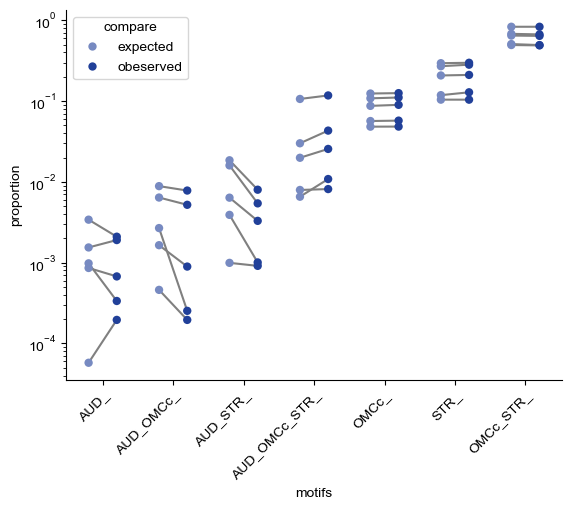

In [63]:

# plot

# set colors for plot
colors = [blue_cmp.colors[-100], blue_cmp.colors[-1]]
# set order of xaxis
order = ["AUD_", "AUD_OMCc_", "AUD_STR_", "AUD_OMCc_STR_", "OMCc_", "STR_", "OMCc_STR_"]

ax = sns.stripplot(x='motifs', y='proportion', hue='compare', palette=[colors[0], colors[1]],
                   dodge=.3, data=mmus_plot, jitter=0, size=6, order=order)

for i in range(len(mmus["motifs"].unique())):
    for (x0, y0), (x1, y1) in zip(ax.collections[2*i].get_offsets(), ax.collections[2*i+1].get_offsets()):
        ax.plot([x0, x1], [y0, y1], color='grey', zorder=0)
# rotate xaxis labels
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

# set yaxis on log
plt.yscale("log")

# get rid of top/side axis
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.savefig(out_path+"mmus_paired.svg", dpi=300, bbox_inches="tight")

plt.show()


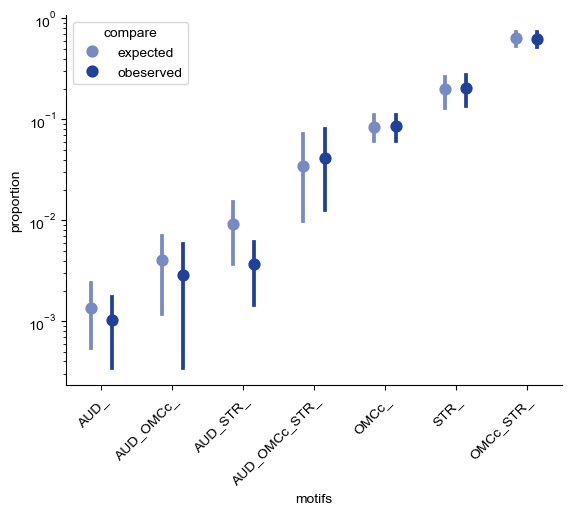

In [64]:

# # set colors for plot
# colors = [blue_cmp.colors[-100], blue_cmp.colors[-1]]
# # set order of xaxis
# order = ["AUD_", "AUD_OMCc_", "AUD_STR_", "AUD_OMCc_STR_", "OMCc_", "STR_", "OMCc_STR_"]


# ax = sns.pointplot(x='motifs', y='proportion', hue='compare', palette=[colors[0], colors[1]],
#                    dodge=.3, data=mmus_plot, order=order, ls="")

# # for i in range(len(motifs)):
# #     for (x0, y0), (x1, y1) in zip(ax.collections[2*i].get_offsets(), ax.collections[2*i+1].get_offsets()):
# #         ax.plot([x0, x1], [y0, y1], color='grey', zorder=0)

# # set yaxis on log
# plt.yscale("log")
# # rotate xaxis labels
# plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
# # get rid of top/side axis
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

# # plt.savefig(out_path+"mmus_avg_se.svg", dpi=300, bbox_inches="tight")


# plt.show()



In [65]:

# sns.scatterplot(mmus, x="p_obs", y="p_calc", hue="motifs", style="mice")
# # plot on log scale
# plt.title("IT - Log scale")
# plt.xscale("log")
# plt.yscale("log")
# plt.axline((0,0), (0.6,0.6), color="red", linestyle="--", alpha=0.5)
# plt.legend(bbox_to_anchor=(1, 1))
# plt.xlabel("Observed proportion")
# plt.ylabel("Expected proportion")
# plt.savefig(out_path+"mmus_motif_scatter.svg", dpi=300, bbox_inches="tight")

# plt.show()


<>:22: SyntaxWarning: invalid escape sequence '\d'
<>:22: SyntaxWarning: invalid escape sequence '\d'
/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_17484/403401976.py:22: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel('$log_{2}$($\dfrac{Observed}{Expected}$)')


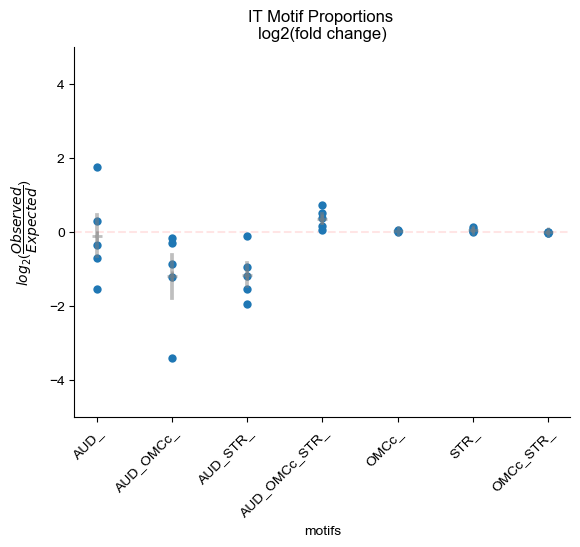

In [66]:

# Calculate foldchange:
mmus["fc"] = mmus["p_obs"]/mmus["p_calc"]
mmus["log2fc"] = np.log2(mmus["fc"])

sns.stripplot(x='motifs', y='log2fc', color="tab:blue",
                data=mmus, jitter=0, size=6, order=order)
sns.pointplot(mmus, x="motifs", y="log2fc", order=order, color="gray",
              alpha=0.5, ls="", zorder=10, marker="+", errorbar="se")
plt.axline((0,0), (1,0), color="red", ls="--", alpha=0.1)

# rotate xaxis labels
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

# set limits to equal
plt.ylim(-5,5)

# get rid of top/side axis
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.ylabel('$log_{2}$($\dfrac{Observed}{Expected}$)')

plt.title("IT Motif Proportions \nlog2(fold change)")

# plt.savefig(out_path+"mmus_it_log2fc.svg", dpi=300, bbox_inches="tight")
plt.show()

In [67]:
wilcox_test = {}
for m in mmus["motifs"].unique():
    df_m = mmus[mmus["motifs"]==m]
    wilcox_test[m] = wilcoxon(df_m["p_calc"], df_m["p_obs"])
wilcox_test

{'OMCc_': WilcoxonResult(statistic=0.0, pvalue=0.0625),
 'AUD_': WilcoxonResult(statistic=4.0, pvalue=0.4375),
 'STR_': WilcoxonResult(statistic=1.0, pvalue=0.125),
 'AUD_OMCc_': WilcoxonResult(statistic=0.0, pvalue=0.0625),
 'OMCc_STR_': WilcoxonResult(statistic=0.0, pvalue=0.0625),
 'AUD_STR_': WilcoxonResult(statistic=0.0, pvalue=0.0625),
 'AUD_OMCc_STR_': WilcoxonResult(statistic=0.0, pvalue=0.0625)}

## plot mmus w/ steg:


<>:21: SyntaxWarning: invalid escape sequence '\d'
<>:21: SyntaxWarning: invalid escape sequence '\d'
/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_17484/2834704064.py:21: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel('$log_{2}$($\dfrac{Observed}{Expected}$)')
/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_17484/2834704064.py:5: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:gray'` for the same effect.

  sns.pointplot(fc_plot, x="motifs", y="log2fc", hue="species", color="gray", alpha=0.3,


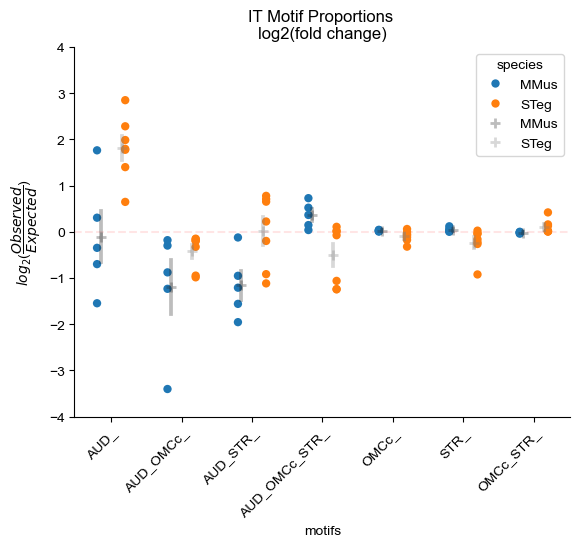

In [69]:
fc_plot = pd.concat([mmus, steg])

sns.stripplot(x='motifs', y='log2fc', hue='species',
                   dodge=0.3, data=fc_plot, jitter=0, size=6, order=order)
sns.pointplot(fc_plot, x="motifs", y="log2fc", hue="species", color="gray", alpha=0.3,
              dodge=0.3, marker="+", order=order, ls="", zorder=10, errorbar="se")

plt.axline((0,0), (1,0), color="red", ls="--", alpha=0.1)

# rotate xaxis labels
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

# set limits to equal
plt.ylim(-4,4)

# get rid of top/side axis
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.ylabel('$log_{2}$($\dfrac{Observed}{Expected}$)')

plt.title("IT Motif Proportions \nlog2(fold change)")

# plt.savefig(out_path+"mmus_steg_it_log2fc.svg", dpi=300, bbox_inches="tight")


plt.show()

# PT cells

In [70]:
plot_areas = ["HY", "AMY", "SNr", "SCm", "PG", "PAG", "BS"]

# Estimate n-totals
n_totals = [estimate_n_total(omc_pt[i], plot_areas) for i in range(len(omc_pt))]

# Count obs motifs
n_obs_motifs = [df_to_motif_proportion(df, areas=plot_areas, proportion=False) for df in omc_pt]
motifs = n_obs_motifs[0].index

# convert to proportions using adjusted n_totals
p_obs_motifs = [n_obs_motifs[i]/n_totals[i] for i in range(len(n_totals))]

# calculate proportions based on independent bulk probabilities adjusted for n_total
p_calc_motifs = [df_to_calc_pab_proportions(df, motifs, adjust_total=True) for df in omc_pt]

motif_strings = TF_to_motifs(motifs)

# put into dataframe - note p_obs is adjusted for n_total
pt_motifs_df = []
for i in range(len(n_totals)):
    df = pd.DataFrame({"motifs":motif_strings, "n_shape":omc_pt[i].shape[0], "n_total":n_totals[i],
                  "n_obs":n_obs_motifs[i], "p_obs":p_obs_motifs[i], "p_calc":p_calc_motifs[i],
                  "mice":metadata.loc[i,"mice"], "species":metadata.loc[i,"species"]})
    pt_motifs_df.append(df)
pt_motifs_df = pd.concat(pt_motifs_df).reset_index(drop=True)

pt_motifs_df

,motifs,n_shape,n_total,n_obs,p_obs,p_calc,mice,species
0,HY_,1313,1325,168,0.126792,0.055741,MMM1,MMus
1,AMY_,1313,1325,3,0.002264,0.000790,MMM1,MMus
2,SNr_,1313,1325,18,0.013585,0.009012,MMM1,MMus
3,SCm_,1313,1325,13,0.009811,0.002553,MMM1,MMus
4,PG_,1313,1325,85,0.064151,0.030364,MMM1,MMus
...,...,...,...,...,...,...,...,...
1519,AMY_BS_HY_PAG_PG_SNr_,216,217,14,0.064516,0.011282,STM7,STeg
1520,AMY_BS_HY_PAG_PG_SCm_,216,217,2,0.009217,0.004538,STM7,STeg
1521,BS_HY_PAG_PG_SCm_SNr_,216,217,1,0.004608,0.003356,STM7,STeg
1522,AMY_BS_PAG_PG_SCm_SNr_,216,217,10,0.046083,0.021805,STM7,STeg


In [71]:
# Get ranked list of pt motifs for each mouse

for mouse in metadata["mice"]:

    # create ranked list for each mouse
    mouse_df = pt_motifs_df[pt_motifs_df["mice"]==mouse]
    mouse_sort = mouse_df.sort_values(by=["p_obs"], ascending=False)
    rank = 1 # start ranking at 1
    for idx, row in mouse_sort.iterrows():
        pt_motifs_df.loc[idx, "rank"] = rank
        # only increase rank if p_obs more than 0
        if row["p_obs"] > 0:
            rank+=1

pt_motifs_df

,motifs,n_shape,n_total,n_obs,p_obs,p_calc,mice,species,rank
0,HY_,1313,1325,168,0.126792,0.055741,MMM1,MMus,3.0
1,AMY_,1313,1325,3,0.002264,0.000790,MMM1,MMus,38.0
2,SNr_,1313,1325,18,0.013585,0.009012,MMM1,MMus,12.0
3,SCm_,1313,1325,13,0.009811,0.002553,MMM1,MMus,16.0
4,PG_,1313,1325,85,0.064151,0.030364,MMM1,MMus,6.0
...,...,...,...,...,...,...,...,...,...
1519,AMY_BS_HY_PAG_PG_SNr_,216,217,14,0.064516,0.011282,STM7,STeg,3.0
1520,AMY_BS_HY_PAG_PG_SCm_,216,217,2,0.009217,0.004538,STM7,STeg,21.0
1521,BS_HY_PAG_PG_SCm_SNr_,216,217,1,0.004608,0.003356,STM7,STeg,45.0
1522,AMY_BS_PAG_PG_SCm_SNr_,216,217,10,0.046083,0.021805,STM7,STeg,6.0


/Users/eisko/mambaforge/envs/MAPseq_231109/lib/python3.12/site-packages/matplotlib/text.py:753: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/Users/eisko/mambaforge/envs/MAPseq_231109/lib/python3.12/site-packages/matplotlib/text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
/Users/eisko/mambaforge/envs/MAPseq_231109/lib/python3.12/site-packages/matplotlib/text.py:894: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/Users/eisko/mambaforge/envs/MAPseq_231109/lib/python3.12/site-packages/matplotlib/text.py:895: FutureWarning: Calling float on a single element Series

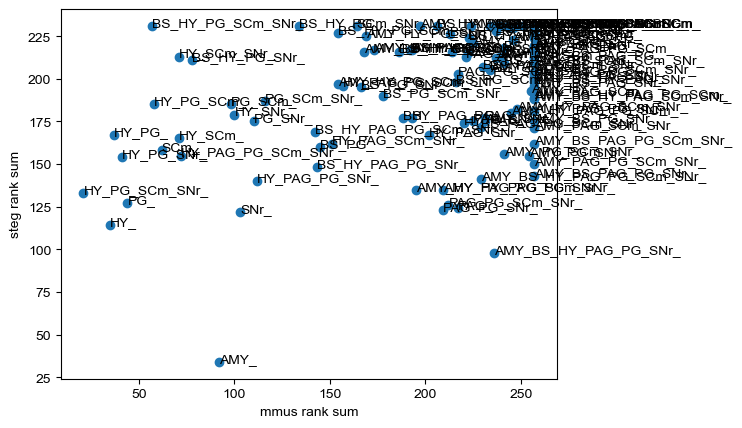

In [5]:
species_rank_sum = pt_motifs_df.groupby(["species", "motifs"]).sum().reset_index()
x = species_rank_sum[species_rank_sum["species"]=="MMus"]
y = species_rank_sum[species_rank_sum["species"]=="STeg"]
plt.scatter(x["rank"],y["rank"] )
for m in species_rank_sum["motifs"].unique():
    xpoint = x[x["motifs"]==m]
    ypoint = y[y["motifs"]==m]
    plt.text(xpoint["rank"], ypoint["rank"], m)

plt.xlabel("mmus rank sum")
plt.ylabel("steg rank sum")
plt.show()

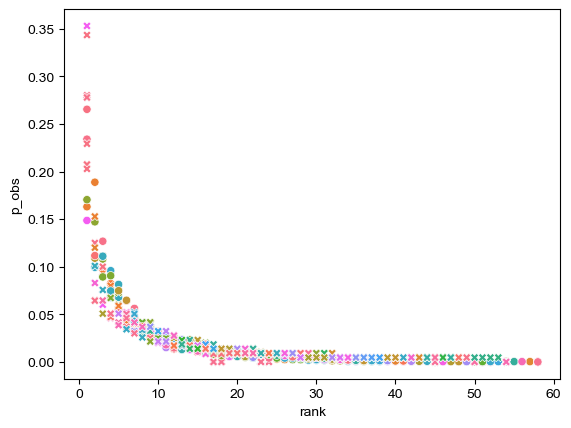

In [6]:
sns.scatterplot(pt_motifs_df, x="rank", y="p_obs", hue="motifs", style="species")
# plt.legend(bbox_to_anchor=(1,1))
plt.legend([],[], frameon=False)

plt.show()


In [7]:
# for m in metadata["mice"]:
#     mouse = rank20[rank20["mice"]==m]
#     print(mouse.sort_values(by="rank"))
rank20 = pt_motifs_df[pt_motifs_df["rank"]<=20]
rank20['motifs'].value_counts()

motifs
HY_                    10
AMY_                   10
PG_                    10
HY_PG_SCm_SNr_          9
SCm_                    9
                       ..
BS_                     2
AMY_BS_HY_PAG_SCm_      2
AMY_BS_HY_PAG_PG_       2
AMY_BS_PG_SCm_SNr_      2
AMY_BS_PAG_SCm_SNr_     2
Name: count, Length: 127, dtype: int64

In [8]:
steg_rank20 = rank20[rank20["species"]=="STeg"]
mmus_rank20 = rank20[rank20["species"]=="MMus"]

print(steg_rank20["motifs"].value_counts())
print(mmus_rank20["motifs"].value_counts())


motifs
AMY_                     7
SNr_                     6
HY_                      5
PG_                      5
AMY_BS_HY_PAG_PG_SNr_    5
                        ..
AMY_PG_SCm_              2
AMY_BS_SCm_              2
AMY_PAG_PG_              2
AMY_BS_PG_               2
AMY_BS_PAG_              2
Name: count, Length: 127, dtype: int64
motifs
HY_                       5
SCm_                      5
PG_                       5
HY_SCm_SNr_               5
HY_PG_                    5
BS_HY_PG_SCm_SNr_         5
HY_PG_SCm_SNr_            5
HY_PG_SNr_                5
HY_SCm_                   4
HY_PG_SCm_                4
HY_PAG_PG_SCm_SNr_        4
HY_SNr_                   3
SNr_                      3
AMY_                      3
BS_HY_PG_SNr_             3
PG_SCm_SNr_               3
PG_SNr_                   3
BS_HY_PAG_PG_SCm_SNr_     3
AMY_BS_HY_PG_SCm_SNr_     2
AMY_HY_PG_SCm_SNr_        2
BS_HY_PG_                 2
BS_HY_PAG_PG_SNr_         2
HY_PAG_PG_SNr_            2
AMY_HY

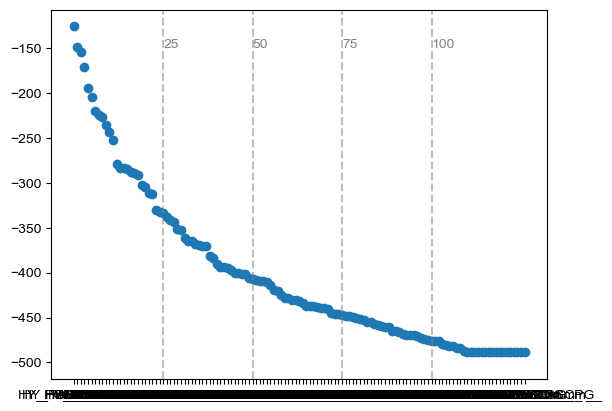

In [9]:
rank_sum = pt_motifs_df.groupby("motifs").sum()["rank"]
rank_sort = rank_sum.sort_values()
plt.scatter(rank_sort.index, -rank_sort)

plt.axline((25,-500), (25,-250), color="gray", ls="--", alpha=0.5 )
plt.text(25,-150, "25", color="gray")

plt.axline((50,-500), (50,-250), color="gray", ls="--", alpha=0.5 )
plt.text(50,-150, "50", color="gray")

plt.axline((75,-500), (75,-250), color="gray", ls="--", alpha=0.5 )
plt.text(75,-150, "75", color="gray")

plt.axline((100,-500), (100,-250), color="gray", ls="--", alpha=0.5 )
plt.text(100,-150, "100", color="gray")

plt.show()

In [11]:
# look at motifs 10 at a time
steg_pt_motifs = pt_motifs_df[pt_motifs_df["species"]=="STeg"]

# make plottable df
# plot paired dot plot
plot_areas = ['HY', 'AMY', 'SNr', 'SCm', 'PG', 'PAG', 'BS']


# isolate to singing mice
steg = pt_motifs_df[pt_motifs_df["species"]=="STeg"].reset_index(drop=True)

# reform so that can use seaborn to plot
exp_steg_plot = steg.copy()
obs_steg_plot = steg.copy()
exp_steg_plot["proportion"] = steg["p_calc"]
obs_steg_plot["proportion"] = steg["p_obs"]
exp_steg_plot["compare"] = "expected"
obs_steg_plot["compare"] = "obeserved"

steg_plot = pd.concat([exp_steg_plot, obs_steg_plot]).drop(columns=["p_obs", "p_calc"]).reset_index(drop=True)
steg_plot

,motifs,n_shape,n_total,n_obs,mice,species,rank,proportion,compare
0,HY_,93,96,12,STM1,STeg,2.0,0.072760,expected
1,AMY_,93,96,22,STM1,STeg,1.0,0.013618,expected
2,SNr_,93,96,1,STM1,STeg,15.0,0.040190,expected
3,SCm_,93,96,1,STM1,STeg,16.0,0.001997,expected
4,PG_,93,96,0,STM1,STeg,24.0,0.016430,expected
...,...,...,...,...,...,...,...,...,...
1773,AMY_BS_HY_PAG_PG_SNr_,216,217,14,STM7,STeg,3.0,0.064516,obeserved
1774,AMY_BS_HY_PAG_PG_SCm_,216,217,2,STM7,STeg,21.0,0.009217,obeserved
1775,BS_HY_PAG_PG_SCm_SNr_,216,217,1,STM7,STeg,45.0,0.004608,obeserved
1776,AMY_BS_PAG_PG_SCm_SNr_,216,217,10,STM7,STeg,6.0,0.046083,obeserved


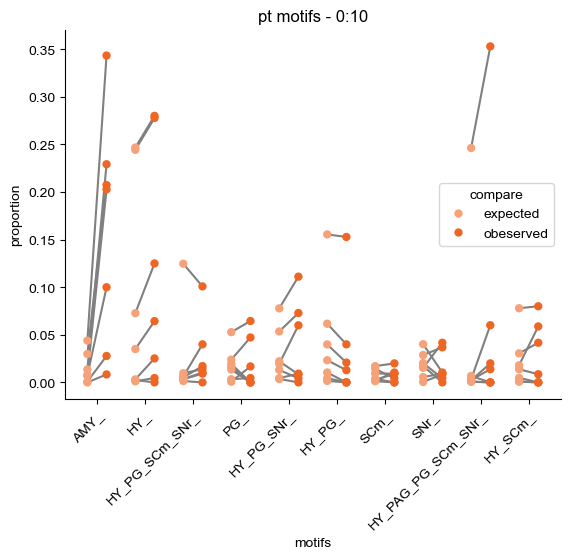

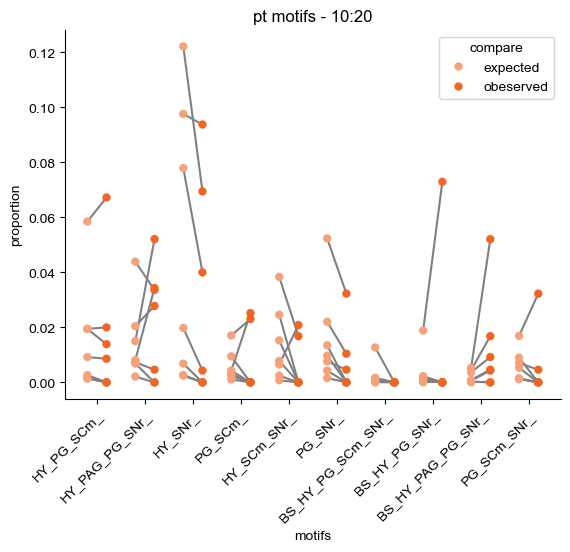

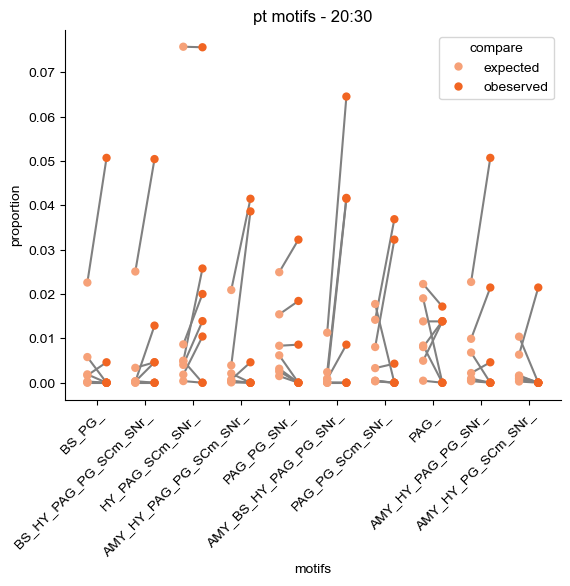

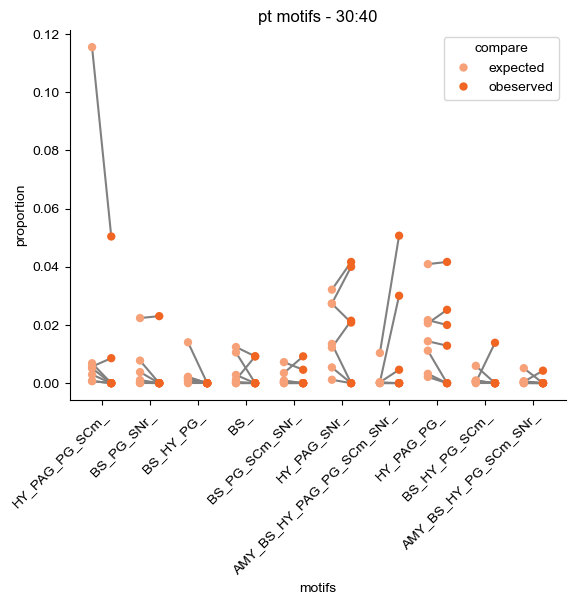

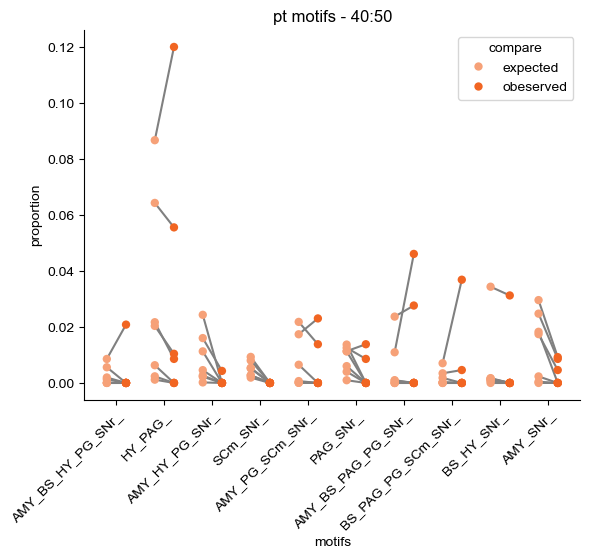

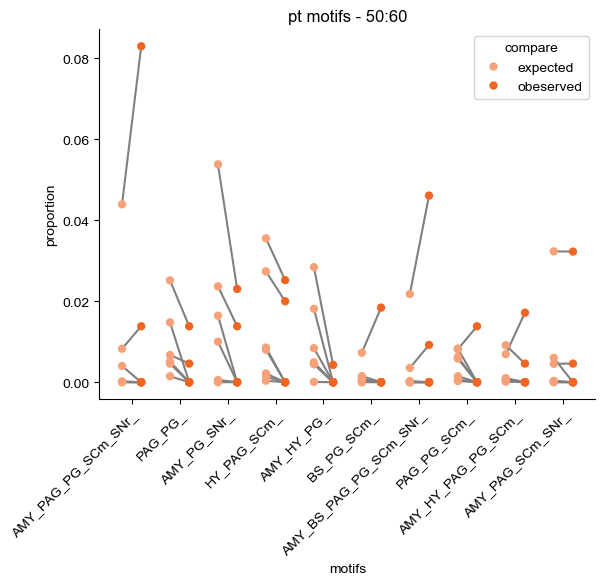

In [12]:


# set colors for plot
colors = [orange_cmp.colors[-100], orange_cmp.colors[-1]]


# make plots for every 10 motifs for top 50 motifs
for r in range(6):
    # set order of xaxis
    order = rank_idx[r*10:r*10+10]["motifs"]
    # only keep motifs to plot
    plot_df = steg_plot[steg_plot["motifs"].isin(order)].reset_index(drop=True)

    ax = sns.stripplot(x='motifs', y='proportion', hue='compare', palette=[colors[0], colors[1]],
                    dodge=.3, data=plot_df, jitter=0, size=6, order=order)

    for i in range(10):
        for (x0, y0), (x1, y1) in zip(ax.collections[2*i].get_offsets(), ax.collections[2*i+1].get_offsets()):
            ax.plot([x0, x1], [y0, y1], color='grey', zorder=0)
    # rotate xaxis labels
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

    # set yaxis on log
    # plt.yscale("log")

    # get rid of top/side axis
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.title("pt motifs - "+str(r*10)+":"+str(r*10+10))

    # plt.savefig(out_path+"_steg_individ_paired.svg", dpi=300, bbox_inches="tight")

    plt.show()


## calculate cut-offs?
<img src="neuron_estimate.png">


In [15]:
# use 36 as cutoff

# filter out motifs that are observed <36 times
pt_cutoff = pt_motifs_df[pt_motifs_df["n_obs"]>=36]
pt_cutoff[pt_cutoff["species"]=="STeg"]

,motifs,n_shape,n_total,n_obs,p_obs,p_calc,mice,species,rank
1017,AMY_,211,217,45,0.207373,0.029863,STF4,STeg,1.0
1251,HY_PAG_PG_SCm_SNr_,119,119,42,0.352941,0.246193,STM5,STeg,1.0
1271,AMY_,225,233,80,0.343348,0.043898,STF6,STeg,1.0
1398,AMY_,216,217,44,0.202765,0.007622,STM7,STeg,1.0


In [4]:
all_sort = []

for i in range(len(st_pt)):
    ls = st_pt[i].sum()[:-1]
    ls_sort = ls.sort_values(ascending=False)
    all_sort.append(ls_sort.index)

bulk_rank_df = pd.DataFrame(all_sort)
bulk_rank_df


NameError: name 'st_pt' is not defined

In [23]:
# percentage of AUD/PT, total
for i in range(len(st_pt)):
    df = st_pt[i]
    aud_prop = df.sum()["AUD"]/df.shape[0]
    print(aud_prop, df.shape[0])

0.12903225806451613 93
0.02127659574468085 47
0.02857142857142857 70
0.08530805687203792 211
0.19327731092436976 119
0.24444444444444444 225
0.27314814814814814 216


In [35]:
bulk_rank_df.shape

(7, 12)

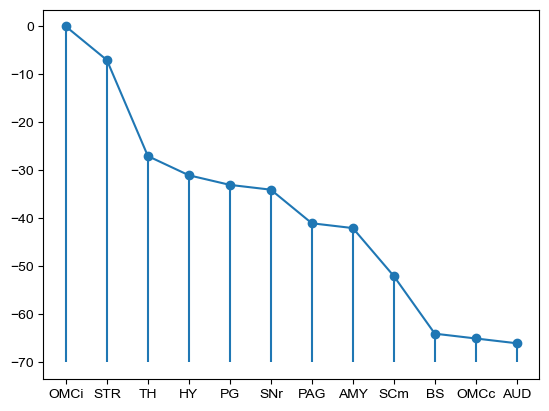

In [46]:
# sum rank for bulk projections of PT
bulk_rank = {'OMCi':0, 'OMCc':0, 'AUD':0, 'STR':0, 'TH':0, 'HY':0, 'AMY':0, 'SNr':0, 'SCm':0, 'PG':0,
       'PAG':0, 'BS':0}

for idx_row in range(bulk_rank_df.shape[0]): # iterate through rows
    for rank in range(bulk_rank_df.shape[1]): # iterate through columns
        area = bulk_rank_df.iloc[idx_row, rank]
        bulk_rank[area] += rank

pt_bulk_ranks = pd.Series(bulk_rank).sort_values()

plt.scatter(pt_bulk_ranks.index, -pt_bulk_ranks)
plt.plot(pt_bulk_ranks.index, -pt_bulk_ranks)

plt.vlines(pt_bulk_ranks.index, -70, -pt_bulk_ranks)
plt.show()
    

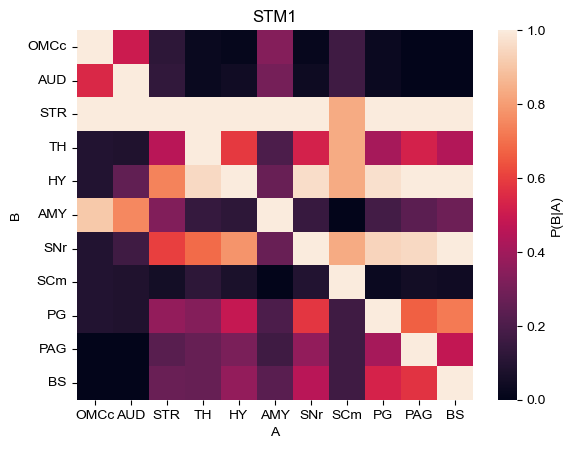

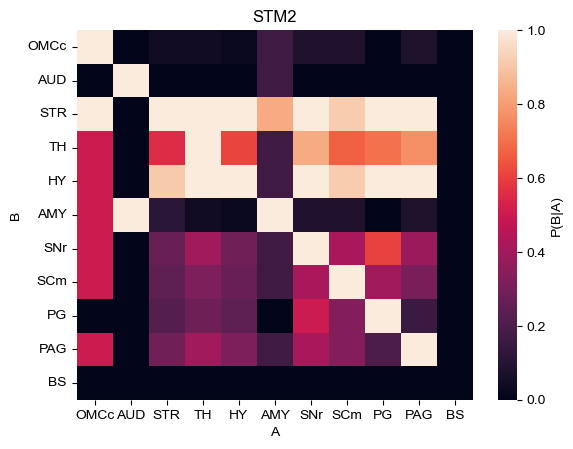

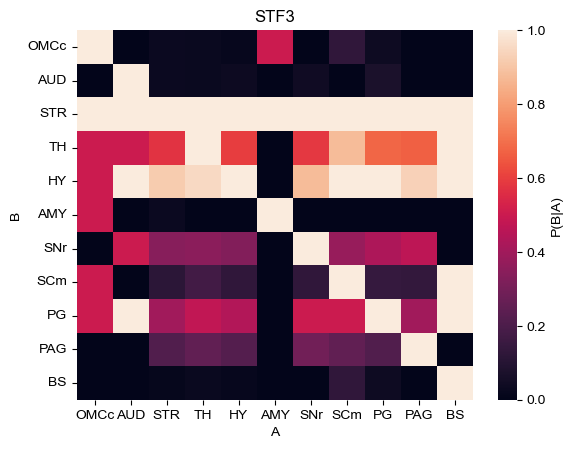

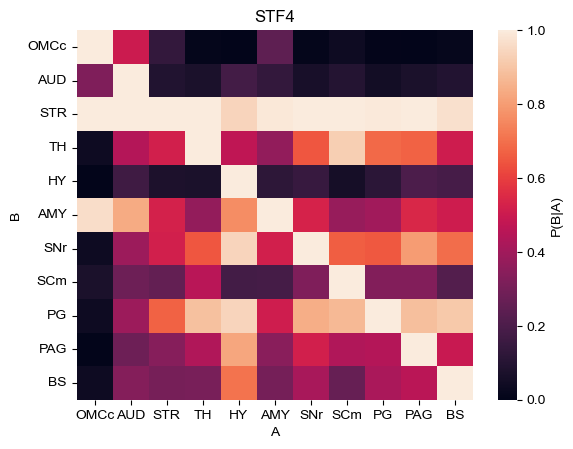

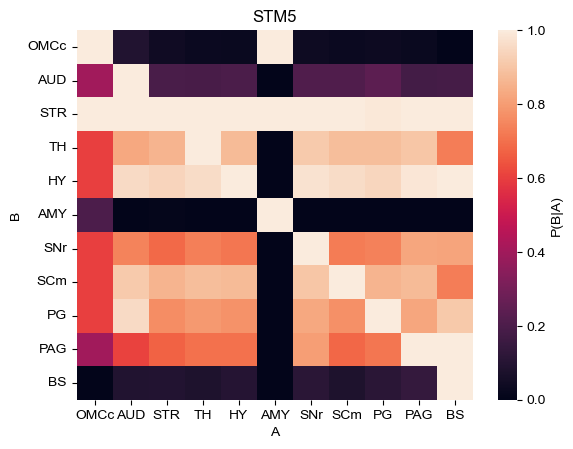

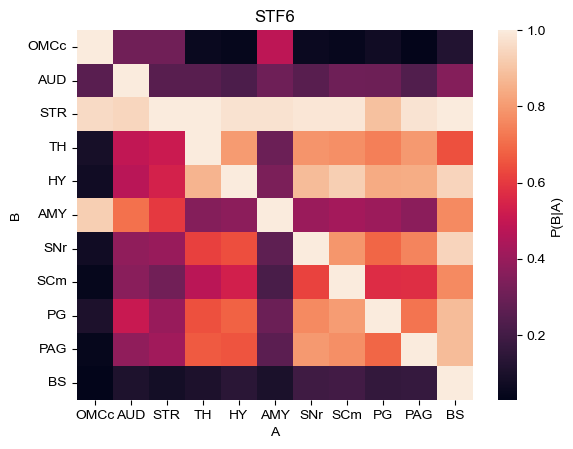

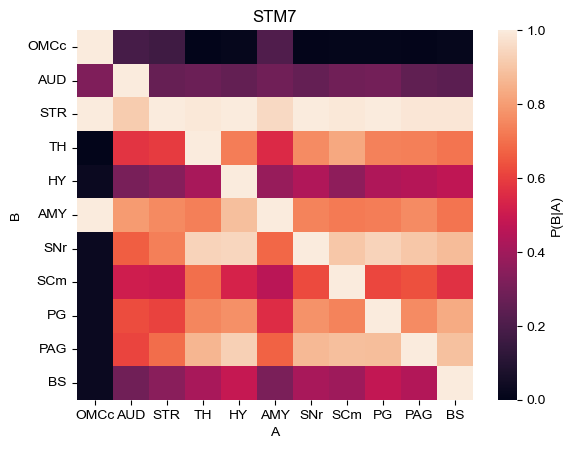

In [62]:
# plot conditional probability
st_pt_pab = []
for df in st_pt:
    pab_df = calc_PAB(df)
    st_pt_pab.append(pab_df)

st_mice = metadata[metadata["species"]=="STeg"]["mice"].reset_index(drop=True)


# fig, axs = plt.subplots(3,3, figsize=(10,10))
# i = 0
# for ax in axs.flat:
#     if i >=7:
#         ax.axis("off")
#     else:
#         hm = pab_heatmap(st_pt_pab[i][0], areas=st_pt_pab[i][1], title=st_mice[i])
#         ax = hm
#     i+=1
# plt.show()

for i in range(len(st_mice)):
    pab_heatmap(st_pt_pab[i][0], areas=st_pt_pab[i][1], title=st_mice[i])
    plt.savefig(out_path+"pab_corr_"+st_mice[i]+".png", dpi=300, bbox_inches="tight")
    plt.show()

## PAG/HY/SNr/AMY
- based on known PAG circuit(s) and PAB data, decided to focus on HY, SNr, AMY

In [72]:
plot_areas = ["PAG", "HY", "SNr", "AMY", "other"]
pt_areas = ['OMCc', 'AUD', 'STR', 'TH', 'HY', 'AMY', 'SNr', 'SCm', 'PG',
       'PAG', 'BS']

# reduce pt to pt areas
omc_pt_reduced = []
for df in omc_pt:
    df_d = df.drop(columns=["OMCi", "OMCc", "AUD", "STR", "TH", "type"]) # decided to ignore OMCc/AUD/STR/TH -> can add back in later if you want
    other = df[["SCm", "PG", "BS"]] # set other as SCm, PG, and BS
    other_sum = other.sum(axis=1)
    other_sum[other_sum>0] = 1 # rebinarize
    df_d["other"] = other_sum
    omc_pt_reduced.append(df_d)
omc_pt_reduced[0]


,HY,AMY,SNr,SCm,PG,PAG,BS,other
10422,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
10423,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
10424,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
10425,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10426,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
11730,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
11731,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
11732,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11733,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [73]:
plot_areas = ["PAG", "HY", "SNr", "AMY", "other"]
pt_areas = ['OMCc', 'AUD', 'STR', 'TH', 'HY', 'AMY', 'SNr', 'SCm', 'PG',
       'PAG', 'BS']

# Estimate n-totals
n_totals = [estimate_n_total(omc_pt_reduced[i], plot_areas) for i in range(len(omc_pt_reduced))]

# Count obs motifs
n_obs_motifs = [df_to_motif_proportion(df, areas=plot_areas, proportion=False) for df in omc_pt_reduced]
motifs = n_obs_motifs[0].index

# convert to proportions using adjusted n_totals
p_obs_motifs = [n_obs_motifs[i]/n_totals[i] for i in range(len(n_totals))]

# calculate proportions based on independent bulk probabilities adjusted for n_total
p_calc_motifs = [df_to_calc_pab_proportions(df, motifs, adjust_total=True) for df in omc_pt_reduced]

motif_strings = TF_to_motifs(motifs)

# put into dataframe - note p_obs is adjusted for n_total
pt_motifs_df = []
for i in range(len(n_totals)):
    df = pd.DataFrame({"motifs":motif_strings, "n_shape":omc_pt_reduced[i].shape[0], "n_total":n_totals[i],
                  "n_obs":n_obs_motifs[i], "p_obs":p_obs_motifs[i], "p_calc":p_calc_motifs[i],
                  "mice":metadata.loc[i,"mice"], "species":metadata.loc[i,"species"]})
    pt_motifs_df.append(df)
pt_motifs_df = pd.concat(pt_motifs_df).reset_index(drop=True)

pt_motifs_df


,motifs,n_shape,n_total,n_obs,p_obs,p_calc,mice,species
0,PAG_,1313,1330,0,0.000000,0.000243,MMM1,MMus
1,HY_,1313,1330,168,0.126316,0.074214,MMM1,MMus
2,SNr_,1313,1330,18,0.013534,0.012225,MMM1,MMus
3,AMY_,1313,1330,3,0.002256,0.001075,MMM1,MMus
4,other_,1313,1330,121,0.090977,0.054482,MMM1,MMus
...,...,...,...,...,...,...,...,...
367,HY_PAG_SNr_other_,216,217,5,0.023041,0.026673,STM7,STeg
368,AMY_HY_PAG_other_,216,217,3,0.013825,0.036075,STM7,STeg
369,AMY_PAG_SNr_other_,216,217,44,0.202765,0.173326,STM7,STeg
370,AMY_HY_SNr_other_,216,217,1,0.004608,0.040984,STM7,STeg


In [74]:
motif_sum = pt_motifs_df.groupby("motifs").sum()
motif_sum = motif_sum.drop(columns=["mice", "species"])
rank_order = motif_sum.sort_values(by="p_obs", ascending=False).index
rank_order

Index(['HY_SNr_other_', 'AMY_', 'HY_other_', 'HY_PAG_SNr_other_', 'HY_',
       'other_', 'AMY_HY_PAG_SNr_other_', 'HY_SNr_', 'SNr_other_',
       'HY_PAG_other_', 'AMY_PAG_SNr_other_', 'PAG_SNr_other_', 'SNr_',
       'HY_PAG_', 'AMY_HY_SNr_other_', 'HY_PAG_SNr_', 'AMY_SNr_other_',
       'PAG_other_', 'PAG_', 'AMY_HY_PAG_other_', 'AMY_HY_other_',
       'AMY_PAG_other_', 'AMY_other_', 'AMY_SNr_', 'PAG_SNr_', 'AMY_HY_',
       'AMY_HY_SNr_', 'AMY_HY_PAG_SNr_', 'AMY_PAG_SNr_', 'AMY_PAG_',
       'AMY_HY_PAG_'],
      dtype='object', name='motifs')

In [75]:
# plot paired dot plot

# isolate to singing mice
steg = pt_motifs_df[pt_motifs_df["species"]=="STeg"].reset_index(drop=True)

# calculate fold change (p_obs/p_calc)

# reform so that can use seaborn to plot
exp_steg_plot = steg.copy()
obs_steg_plot = steg.copy()
exp_steg_plot["proportion"] = steg["p_calc"]
obs_steg_plot["proportion"] = steg["p_obs"]
exp_steg_plot["compare"] = "expected"
obs_steg_plot["compare"] = "obeserved"

steg_plot = pd.concat([exp_steg_plot, obs_steg_plot]).drop(columns=["p_obs", "p_calc"]).reset_index(drop=True)

steg_plot


,motifs,n_shape,n_total,n_obs,mice,species,proportion,compare
0,PAG_,93,97,0,STM1,STeg,0.010377,expected
1,HY_,93,97,12,STM1,STeg,0.088063,expected
2,SNr_,93,97,1,STM1,STeg,0.049181,expected
3,AMY_,93,97,22,STM1,STeg,0.016816,expected
4,other_,93,97,1,STM1,STeg,0.032500,expected
...,...,...,...,...,...,...,...,...
429,HY_PAG_SNr_other_,216,217,5,STM7,STeg,0.023041,obeserved
430,AMY_HY_PAG_other_,216,217,3,STM7,STeg,0.013825,obeserved
431,AMY_PAG_SNr_other_,216,217,44,STM7,STeg,0.202765,obeserved
432,AMY_HY_SNr_other_,216,217,1,STM7,STeg,0.004608,obeserved


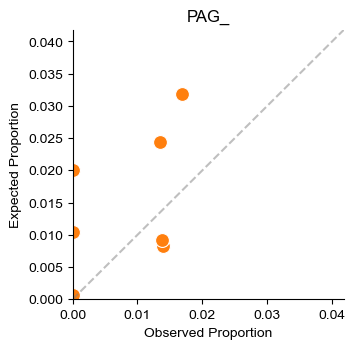

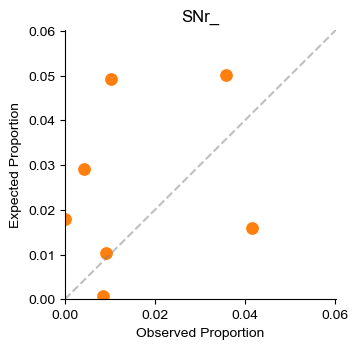

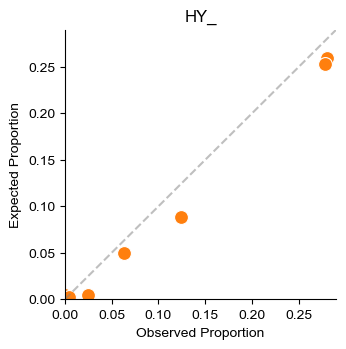

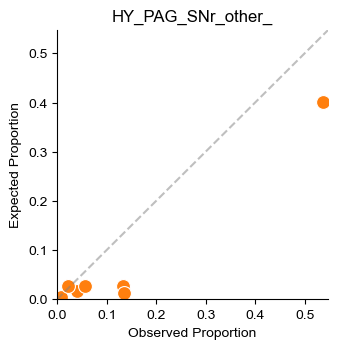

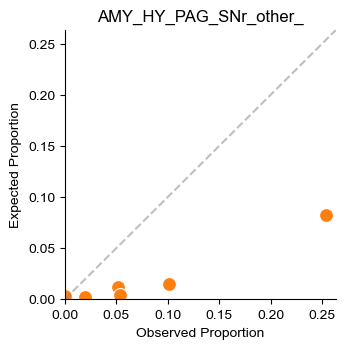

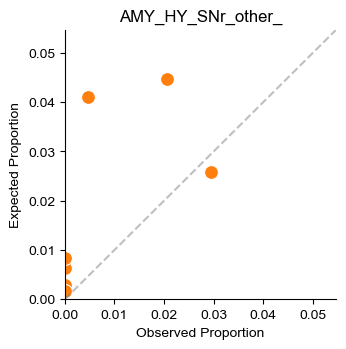

In [76]:


# single motif x/y plot

plot_motifs = ["PAG_", "SNr_", "HY_", "HY_PAG_SNr_other_", "AMY_HY_PAG_SNr_other_", "AMY_HY_SNr_other_"]


for m in plot_motifs:
    fig, axs = plt.subplots(1,1, figsize=(3.5,3.5))

    plot_df = steg[steg["motifs"]==m]


    sns.scatterplot(plot_df, x="p_obs", y="p_calc", color="tab:orange", s=100)
    plt.title(m)

    plt.xlabel("Observed Proportion")
    plt.ylabel("Expected Proportion")

    # draw x=y line
    plt.axline((0,0), (0.02, 0.02), color="gray", linestyle="--", alpha=0.5)

    # get max to get bounds to plot
    max = pd.concat([plot_df["p_calc"], plot_df["p_obs"]]).max()
    plt.xlim(0,max+0.01)
    plt.ylim(0,max+0.01)

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # plt.savefig(out_path+m+"_steg_obs_exp_scatter.svg", dpi=300, bbox_inches="tight")

    plt.show()
    


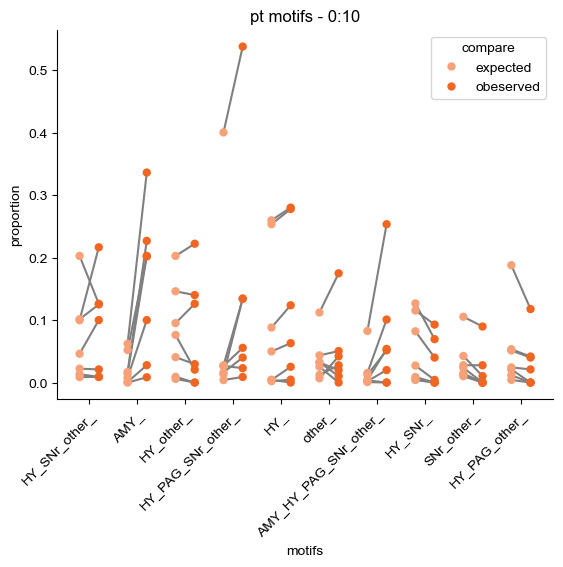

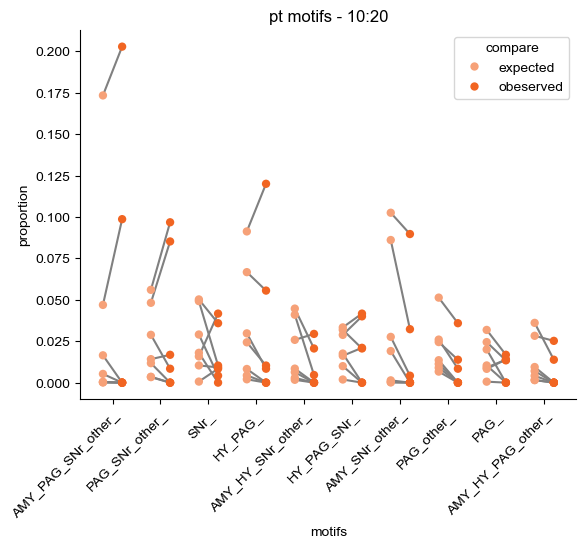

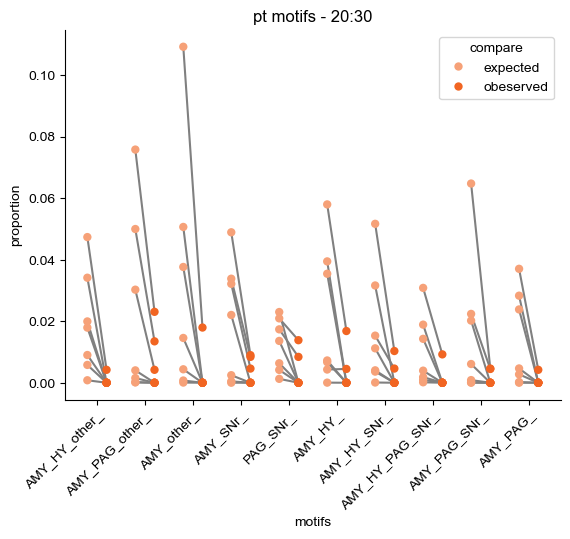

In [77]:
# plot

# set colors for plot
colors = [orange_cmp.colors[-100], orange_cmp.colors[-1]]
# set order of xaxis
# order = rank_order.values

# Make plot for every 10 motifs
for r in range(3):
    # set order of xaxis
    order = rank_order[r*10:r*10+10]
    # only keep motifs to plot
    plot_df = steg_plot[steg_plot["motifs"].isin(order)].reset_index(drop=True)

    ax = sns.stripplot(x='motifs', y='proportion', hue='compare', palette=[colors[0], colors[1]],
                    dodge=.3, data=plot_df, jitter=0, size=6, order=order)

    for i in range(10):
        for (x0, y0), (x1, y1) in zip(ax.collections[2*i].get_offsets(), ax.collections[2*i+1].get_offsets()):
            ax.plot([x0, x1], [y0, y1], color='grey', zorder=0)
    # rotate xaxis labels
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

    # set yaxis on log
    # plt.yscale("log")

    # get rid of top/side axis
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.title("pt motifs - "+str(r*10)+":"+str(r*10+10))

    # plt.savefig(out_path+"_steg_individ_paired.svg", dpi=300, bbox_inches="tight")

    plt.show()


# # plot first 
# ax = sns.stripplot(x='motifs', y='proportion', hue='compare', palette=[colors[0], colors[1]],
#                    dodge=.3, data=steg_plot, jitter=0, size=6, order=order)

# for i in range(len(steg["motifs"].unique())):
#     for (x0, y0), (x1, y1) in zip(ax.collections[2*i].get_offsets(), ax.collections[2*i+1].get_offsets()):
#         ax.plot([x0, x1], [y0, y1], color='grey', zorder=0)
# # rotate xaxis labels
# plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

# # set yaxis on log
# # plt.yscale("log")

# # get rid of top/side axis
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

# # plt.savefig(out_path+"_steg_individ_paired.svg", dpi=300, bbox_inches="tight")

# plt.show()



<>:31: SyntaxWarning: invalid escape sequence '\d'
<>:31: SyntaxWarning: invalid escape sequence '\d'
/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_17484/2846225386.py:31: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel('$log_{2}$($\dfrac{Observed}{Expected}$)')
/Users/eisko/mambaforge/envs/MAPseq_231109/lib/python3.12/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


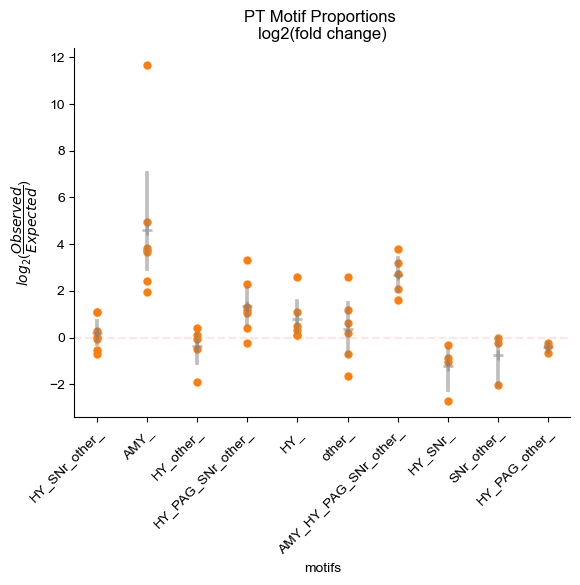

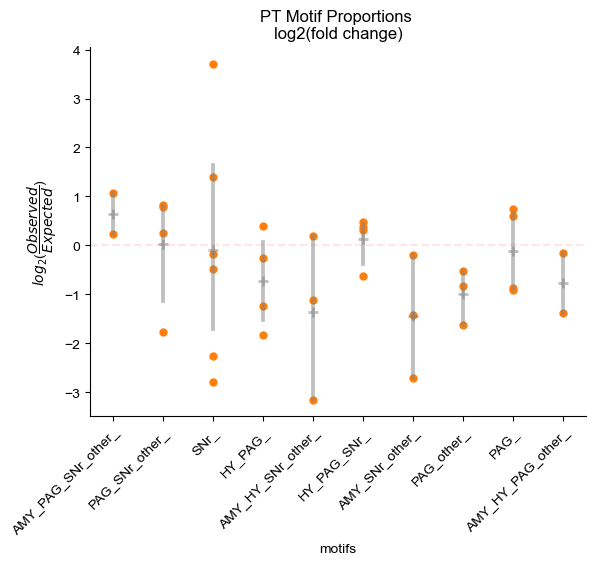

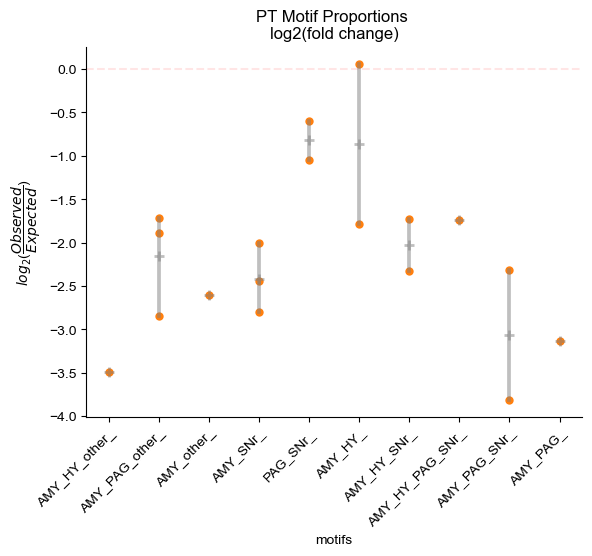

In [78]:
# calculate fold change
# Calculate foldchange:
steg["fc"] = steg["p_obs"]/steg["p_calc"]
steg["log2fc"] = np.log2(steg["fc"])

# Make plot for every 10 motifs
for r in range(3):
    # set order of xaxis
    order = rank_order[r*10:r*10+10]
    # only keep motifs to plot
    plot_df = steg[steg["motifs"].isin(order)].reset_index(drop=True)


    sns.stripplot(x='motifs', y='log2fc', color="tab:orange",
                    data=plot_df, jitter=0, size=6, order=order)
    sns.pointplot(plot_df, x="motifs", y="log2fc", order=order, color="gray",
                alpha=0.5, ls="", zorder=10, marker="+")
    plt.axline((0,0), (1,0), color="red", ls="--", alpha=0.1)

    # rotate xaxis labels
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

    # set limits to equal
    # plt.ylim(-3,3)

    # get rid of top/side axis
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.ylabel('$log_{2}$($\dfrac{Observed}{Expected}$)')

    plt.title("PT Motif Proportions \nlog2(fold change)")

    plt.show()

In [80]:
# wilcoxon test

wilcox_test = {}
for m in steg["motifs"].unique():
    df_m = steg[steg["motifs"]==m]
    wilcox_test[m] = wilcoxon(df_m["p_calc"], df_m["p_obs"])
wilcox_test

{'PAG_': WilcoxonResult(statistic=5.0, pvalue=0.15625),
 'HY_': WilcoxonResult(statistic=2.0, pvalue=0.046875),
 'SNr_': WilcoxonResult(statistic=8.0, pvalue=0.375),
 'AMY_': WilcoxonResult(statistic=0.0, pvalue=0.015625),
 'other_': WilcoxonResult(statistic=11.0, pvalue=0.6875),
 'HY_PAG_': WilcoxonResult(statistic=7.0, pvalue=0.296875),
 'PAG_SNr_': WilcoxonResult(statistic=0.0, pvalue=0.015625),
 'AMY_PAG_': WilcoxonResult(statistic=0.0, pvalue=0.015625),
 'PAG_other_': WilcoxonResult(statistic=0.0, pvalue=0.015625),
 'HY_SNr_': WilcoxonResult(statistic=0.0, pvalue=0.015625),
 'AMY_HY_': WilcoxonResult(statistic=2.0, pvalue=0.046875),
 'HY_other_': WilcoxonResult(statistic=11.0, pvalue=0.6875),
 'AMY_SNr_': WilcoxonResult(statistic=0.0, pvalue=0.015625),
 'SNr_other_': WilcoxonResult(statistic=0.0, pvalue=0.015625),
 'AMY_other_': WilcoxonResult(statistic=0.0, pvalue=0.015625),
 'HY_PAG_SNr_': WilcoxonResult(statistic=10.0, pvalue=0.578125),
 'AMY_HY_PAG_': WilcoxonResult(statistic=

## MMus

<>:124: SyntaxWarning: invalid escape sequence '\d'
<>:124: SyntaxWarning: invalid escape sequence '\d'
/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_17484/209349682.py:124: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel('$log_{2}$($\dfrac{Observed}{Expected}$)')


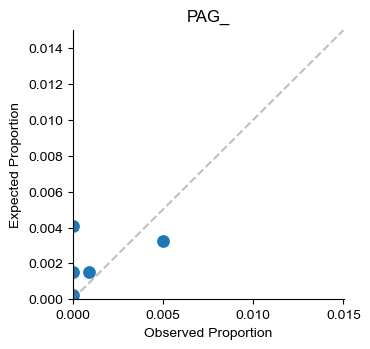

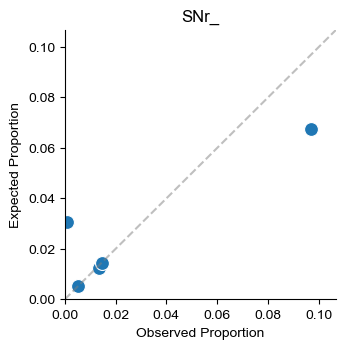

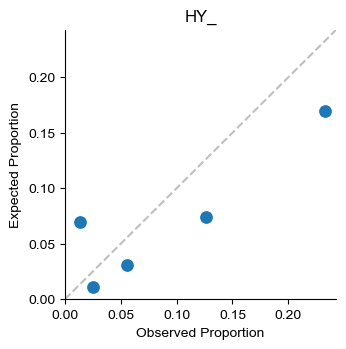

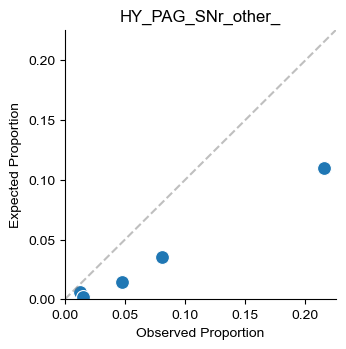

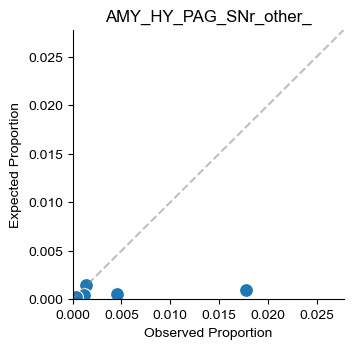

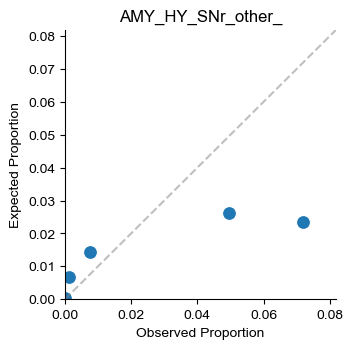

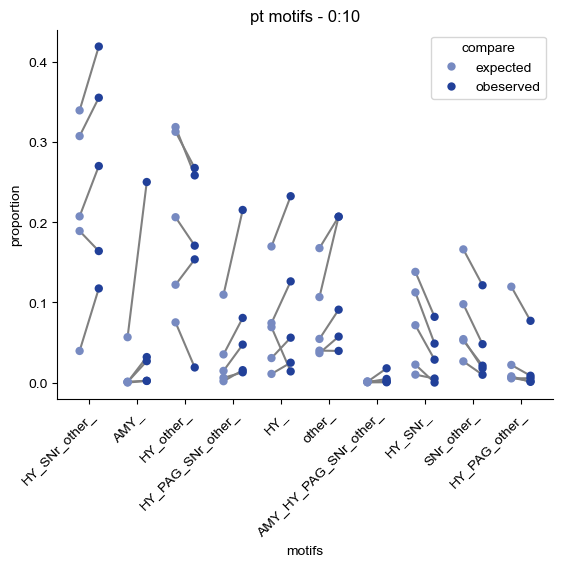

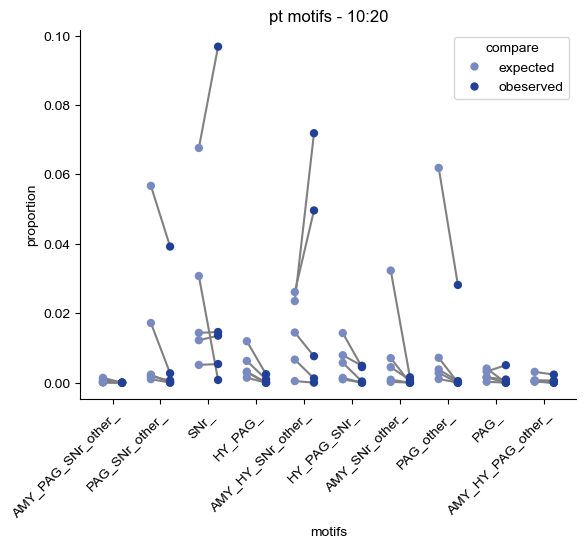

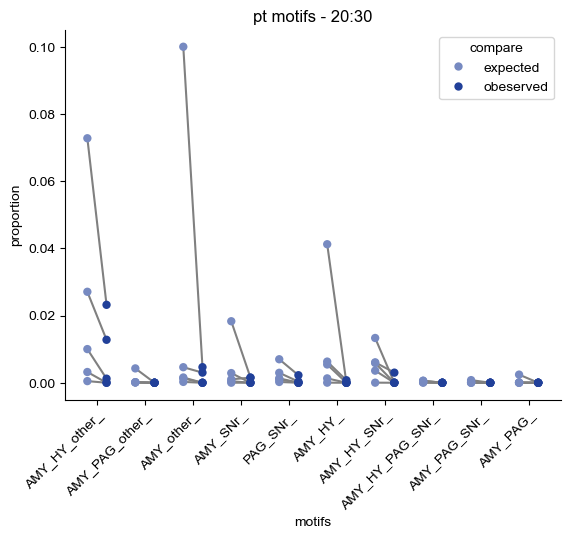

/Users/eisko/mambaforge/envs/MAPseq_231109/lib/python3.12/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


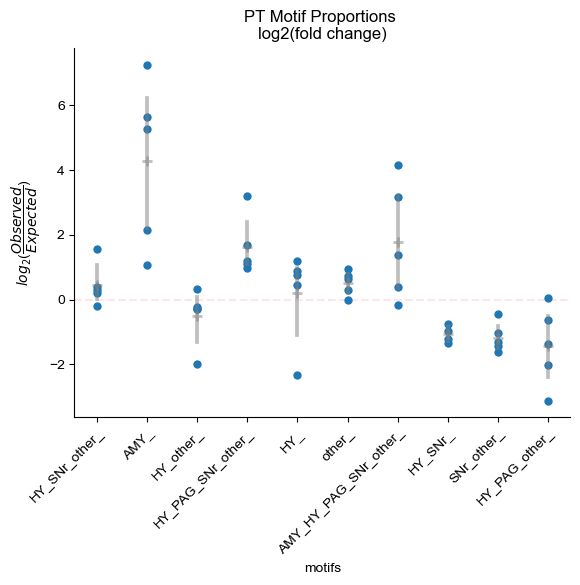

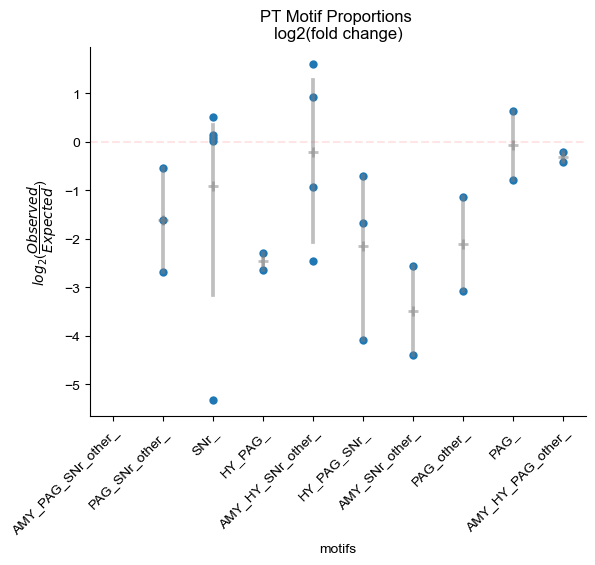

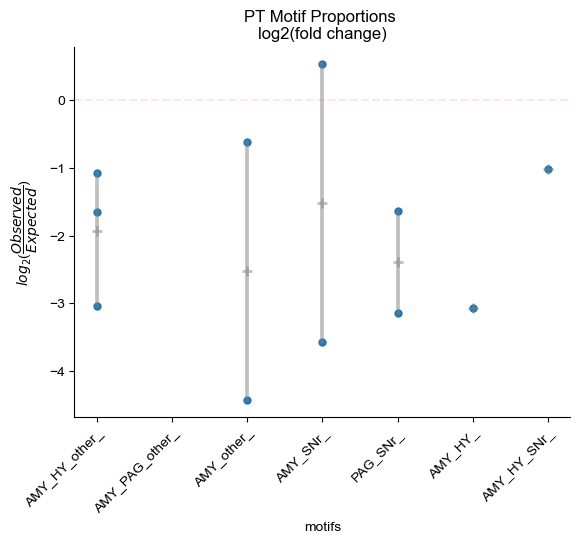

{'PAG_': WilcoxonResult(statistic=4.0, pvalue=0.4375),
 'HY_': WilcoxonResult(statistic=4.0, pvalue=0.4375),
 'SNr_': WilcoxonResult(statistic=5.0, pvalue=0.625),
 'AMY_': WilcoxonResult(statistic=0.0, pvalue=0.0625),
 'other_': WilcoxonResult(statistic=1.0, pvalue=0.125),
 'HY_PAG_': WilcoxonResult(statistic=0.0, pvalue=0.0625),
 'PAG_SNr_': WilcoxonResult(statistic=0.0, pvalue=0.0625),
 'AMY_PAG_': WilcoxonResult(statistic=0.0, pvalue=0.0625),
 'PAG_other_': WilcoxonResult(statistic=0.0, pvalue=0.0625),
 'HY_SNr_': WilcoxonResult(statistic=0.0, pvalue=0.0625),
 'AMY_HY_': WilcoxonResult(statistic=0.0, pvalue=0.0625),
 'HY_other_': WilcoxonResult(statistic=1.0, pvalue=0.125),
 'AMY_SNr_': WilcoxonResult(statistic=3.0, pvalue=0.3125),
 'SNr_other_': WilcoxonResult(statistic=0.0, pvalue=0.0625),
 'AMY_other_': WilcoxonResult(statistic=0.0, pvalue=0.0625),
 'HY_PAG_SNr_': WilcoxonResult(statistic=0.0, pvalue=0.0625),
 'AMY_HY_PAG_': WilcoxonResult(statistic=0.0, pvalue=0.0625),
 'HY_PAG_

In [81]:
# plot paired dot plot

# isolate to singing mice
mmus = pt_motifs_df[pt_motifs_df["species"]=="MMus"].reset_index(drop=True)

# calculate fold change (p_obs/p_calc)

# reform so that can use seaborn to plot
exp_mmus_plot = mmus.copy()
obs_mmus_plot = mmus.copy()
exp_mmus_plot["proportion"] = mmus["p_calc"]
obs_mmus_plot["proportion"] = mmus["p_obs"]
exp_mmus_plot["compare"] = "expected"
obs_mmus_plot["compare"] = "obeserved"

mmus_plot = pd.concat([exp_mmus_plot, obs_mmus_plot]).drop(columns=["p_obs", "p_calc"]).reset_index(drop=True)

mmus_plot



# single motif x/y plot

plot_motifs = ["PAG_", "SNr_", "HY_", "HY_PAG_SNr_other_", "AMY_HY_PAG_SNr_other_", "AMY_HY_SNr_other_"]


for m in plot_motifs:
    fig, axs = plt.subplots(1,1, figsize=(3.5,3.5))

    plot_df = mmus[mmus["motifs"]==m]


    sns.scatterplot(plot_df, x="p_obs", y="p_calc", color="tab:blue", s=100)
    plt.title(m)

    plt.xlabel("Observed Proportion")
    plt.ylabel("Expected Proportion")

    # draw x=y line
    plt.axline((0,0), (0.02, 0.02), color="gray", linestyle="--", alpha=0.5)

    # get max to get bounds to plot
    max = pd.concat([plot_df["p_calc"], plot_df["p_obs"]]).max()
    plt.xlim(0,max+0.01)
    plt.ylim(0,max+0.01)

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # plt.savefig(out_path+m+"_mmus_obs_exp_scatter.svg", dpi=300, bbox_inches="tight")

    plt.show()
    

# plot

# set colors for plot
colors = [blue_cmp.colors[-100], blue_cmp.colors[-1]]
# set order of xaxis
# order = rank_order.values

# Make plot for every 10 motifs
for r in range(3):
    # set order of xaxis
    order = rank_order[r*10:r*10+10]
    # only keep motifs to plot
    plot_df = mmus_plot[mmus_plot["motifs"].isin(order)].reset_index(drop=True)

    ax = sns.stripplot(x='motifs', y='proportion', hue='compare', palette=[colors[0], colors[1]],
                    dodge=.3, data=plot_df, jitter=0, size=6, order=order)

    for i in range(10):
        for (x0, y0), (x1, y1) in zip(ax.collections[2*i].get_offsets(), ax.collections[2*i+1].get_offsets()):
            ax.plot([x0, x1], [y0, y1], color='grey', zorder=0)
    # rotate xaxis labels
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

    # set yaxis on log
    # plt.yscale("log")

    # get rid of top/side axis
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.title("pt motifs - "+str(r*10)+":"+str(r*10+10))

    # plt.savefig(out_path+"_mmus_individ_paired.svg", dpi=300, bbox_inches="tight")

    plt.show()



# calculate fold change
# Calculate foldchange:
mmus["fc"] = mmus["p_obs"]/mmus["p_calc"]
mmus["log2fc"] = np.log2(mmus["fc"])

# Make plot for every 10 motifs
for r in range(3):
    # set order of xaxis
    order = rank_order[r*10:r*10+10]
    # only keep motifs to plot
    plot_df = mmus[mmus["motifs"].isin(order)].reset_index(drop=True)


    sns.stripplot(x='motifs', y='log2fc', color="tab:blue",
                    data=plot_df, jitter=0, size=6, order=order)
    sns.pointplot(plot_df, x="motifs", y="log2fc", order=order, color="gray",
                alpha=0.5, ls="", zorder=10, marker="+")
    plt.axline((0,0), (1,0), color="red", ls="--", alpha=0.1)

    # rotate xaxis labels
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

    # set limits to equal
    # plt.ylim(-3,3)

    # get rid of top/side axis
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.ylabel('$log_{2}$($\dfrac{Observed}{Expected}$)')

    plt.title("PT Motif Proportions \nlog2(fold change)")

    plt.show()
# wilcoxon test

wilcox_test = {}
for m in mmus["motifs"].unique():
    df_m = mmus[mmus["motifs"]==m]
    wilcox_test[m] = wilcoxon(df_m["p_calc"], df_m["p_obs"])
wilcox_test